In [467]:
!pip install catboost
!pip install matplotlib
!pip install mplcyberpunk
!pip install pygal

In [570]:
import numpy as np
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import pandas as pd
from itertools import cycle, islice
import pygal
import pickle
import seaborn as sns
from IPython.display import display, HTML
from catboost import CatBoostClassifier
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import mplcyberpunk

In [568]:
data = pd.read_csv("flows-s1000.csv")
new_data = data[data['proto'] == "DNS"]
new_data = new_data.dropna(subset=['subproto'])
new_data['proto'],new_data['subproto']  = new_data['subproto'], new_data['proto']
data = data.loc[data['proto'] != 'DNS']
data = data.append(new_data)
data = shuffle(data)

C:\Users\iamfi\AppData\Local\Temp\ipykernel_580\625639043.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_test_data)


In [500]:
drop_protos = ["Unknown", "Unencryped_Jabber", "NTP", "Apple","AppleiTunes"]
replace_protos = [("SSL_No_Cert", "SSL")]
data = data[~data["proto"].isin(drop_protos)]
for old_proto, new_proto in replace_protos:
    data = data.replace(old_proto, new_proto)
print(data.head(5))

      bulk0  bulk1  bulk2  bulk3  byte_ratio  client_bulks  \
5729    441   3837      0      0    0.183065             1   
8213    389  24331      0      0    0.043659             1   
9664     41    236      0      0    0.200820             1   
5345     31    107      0      0    0.339130             1   
809     330   5392      0      0    0.093481             1   

      client_bulksize_avg  client_bulksize_dev  client_bytes  \
5729                441.0                  0.0           761   
8213                389.0                  0.0          1093   
9664                 41.0                  0.0            49   
5345                 31.0                  0.0            39   
809                 330.0                  0.0           522   

      client_effeciency  ...  server_bytes  server_efficiency  server_packet0  \
5729           0.579501  ...          4157           0.923021              32   
8213           0.355901  ...         25035           0.971879              32   

In [501]:
proto_clusters = [data[data["proto"] == proto] for proto in data["proto"].unique()]
train_clusters = []
test_clusters = []
for cluster in proto_clusters:
    np.random.seed(42)
    cluster = cluster.iloc[np.random.permutation(len(cluster))]
    split_index = len(cluster) // 3
    train_clusters.append(cluster.iloc[:split_index])
    test_clusters.append(cluster.iloc[split_index:])
train_data = pd.concat(train_clusters)
test_data = pd.concat(test_clusters)
print(data.head(5))

      bulk0  bulk1  bulk2  bulk3  byte_ratio  client_bulks  \
5729    441   3837      0      0    0.183065             1   
8213    389  24331      0      0    0.043659             1   
9664     41    236      0      0    0.200820             1   
5345     31    107      0      0    0.339130             1   
809     330   5392      0      0    0.093481             1   

      client_bulksize_avg  client_bulksize_dev  client_bytes  \
5729                441.0                  0.0           761   
8213                389.0                  0.0          1093   
9664                 41.0                  0.0            49   
5345                 31.0                  0.0            39   
809                 330.0                  0.0           522   

      client_effeciency  ...  server_bytes  server_efficiency  server_packet0  \
5729           0.579501  ...          4157           0.923021              32   
8213           0.355901  ...         25035           0.971879              32   

In [541]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data.drop(["proto", "subproto"], axis=1))
# X_test = scaler.transform(test_data.drop(["proto", "subproto"], axis=1))

labeler = LabelEncoder()
y_train = labeler.fit_transform(train_data["proto"])
# y_test = labeler.transform(test_data["proto"])

X = scaler.fit_transform(train_data.drop(["proto", "subproto"], axis=1))
y = labeler.fit_transform(train_data["proto"])


model = CatBoostClassifier(iterations=5000,
                           task_type="GPU",
                           devices='0:1')

In [544]:
model.fit(X_train, y_train.ravel(), verbose=False,)


In [567]:
print(data.head(5))
# print(labeler.inverse_transform(model.predict(X_test[-201:-200])))
# print(labeler.inverse_transform(y_test[-201:-200]))
l = []
for i in range(1,len(X_test)):
    a = labeler.inverse_transform(model.predict(X_test[i:i+1]))
    l.append(data[i:i+1]['proto'].tolist()[0])
    l.append(data[i:i+1]['client_bytes'].tolist()[0])
    l.append(data[i:i+1]['server_bytes'].tolist()[0])
    l.append(data[i:i+1]['client_payload'].tolist()[0])
    l.append(data[i:i+1]['is_tcp'].tolist()[0])

    
print(l)

      bulk0  bulk1  bulk2  bulk3  byte_ratio  client_bulks  \
5729    441   3837      0      0    0.183065             1   
8213    389  24331      0      0    0.043659             1   
9664     41    236      0      0    0.200820             1   
5345     31    107      0      0    0.339130             1   
809     330   5392      0      0    0.093481             1   

      client_bulksize_avg  client_bulksize_dev  client_bytes  \
5729                441.0                  0.0           761   
8213                389.0                  0.0          1093   
9664                 41.0                  0.0            49   
5345                 31.0                  0.0            39   
809                 330.0                  0.0           522   

      client_effeciency  ...  server_bytes  server_efficiency  server_packet0  \
5729           0.579501  ...          4157           0.923021              32   
8213           0.355901  ...         25035           0.971879              32   

C:\Users\iamfi\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['HTTP', 1093, 25035, 389, 1, 'Google', 49, 244, 41, 0, 'Google', 39, 115, 31, 0, 'HTTP', 522, 5584, 330, 1, 'YouTube', 41, 118, 33, 0, 'Quic', 9244, 64961, 8612, 0, 'Skype', 165, 150, 125, 0, 'Skype', 90, 90, 66, 0, 'Google', 51, 110, 43, 0, 'Quic', 5450, 3516, 5330, 0, 'YouTube', 58, 115, 50, 0, 'HTTP', 6562, 122095, 4130, 1, 'YouTube', 37, 97, 29, 0, 'SSL', 12061, 945844, 1437, 1, 'HTTP', 422, 2950, 326, 1, 'Google', 48, 64, 40, 0, 'HTTP', 508, 327, 412, 1, 'HTTP', 746, 16965, 330, 1, 'HTTP', 420, 2606, 324, 1, 'HTTP', 866, 13766, 386, 1, 'HTTP', 351, 1802, 291, 1, 'HTTP', 424, 2853, 328, 1, 'HTTP', 830, 2547, 702, 1, 'YouTube', 63, 154, 55, 0, 'YouTube', 39, 173, 31, 0, 'HTTP', 937, 23500, 329, 1, 'HTTP', 1821, 1390, 1689, 1, 'Skype', 42, 1808, 34, 0, 'SSL', 742, 4134, 518, 1, 'HTTP', 1218, 38790, 322, 1, 'YouTube', 41, 118, 33, 0, 'Google', 53, 126, 45, 0, 'HTTP', 1226, 38996, 330, 1, 'HTTP', 421, 2150, 325, 1, 'Google', 53, 137, 45, 0, 'HTTP', 767, 600, 479, 1, 'HTTP', 766, 601, 

In [491]:
model.score(X_test, y_test)

0.9905437352245863

In [571]:
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

C:\Users\iamfi\AppData\Local\Temp\ipykernel_580\774274877.py:10: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels=n, loc="best")


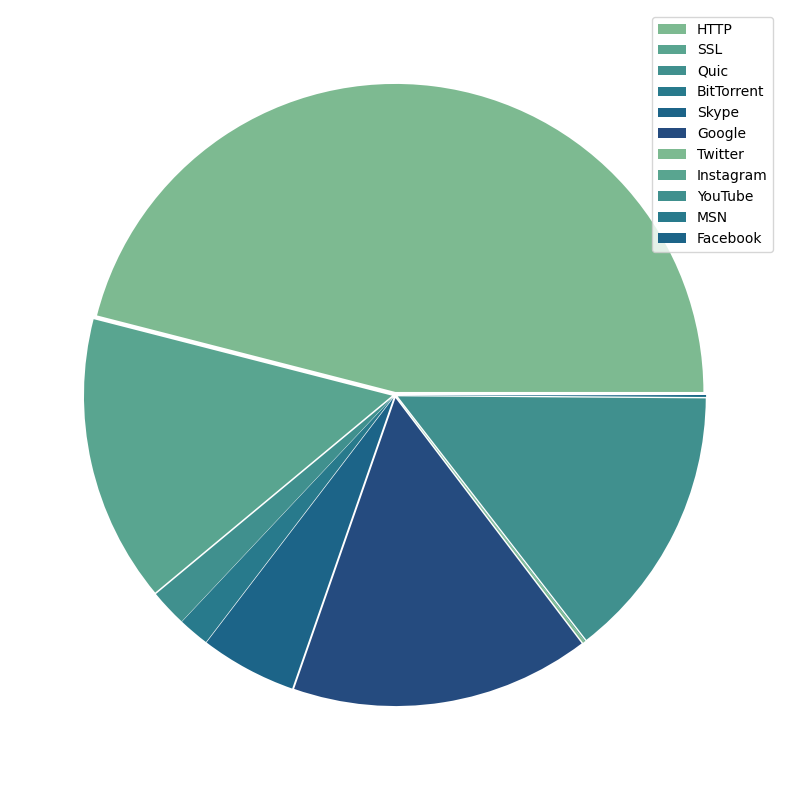

In [461]:
l = []
n = []
for proto in train_data["proto"].unique():
    l.append(len(train_data[train_data["proto"] == proto]))
    n.append(proto.ljust(20).replace(' ',''))
explode = (0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01)
colors = sns.color_palette("crest")
fig = plt.figure(figsize =(10, 10))
patches, texts = plt.pie(l, colors = colors, explode = explode)
plt.legend(patches, labels=n, loc="best")
mplcyberpunk.add_glow_effects()

plt.show()

54066
68470


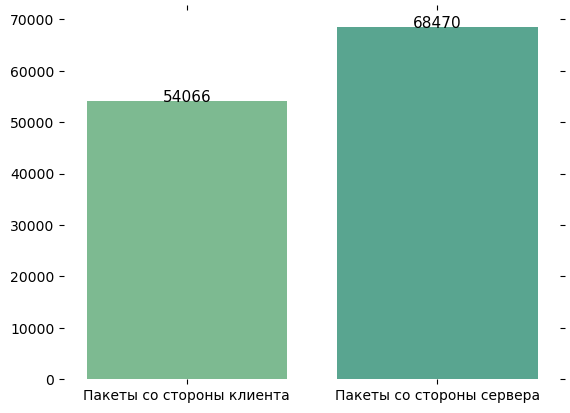

In [462]:
l = train_data['client_packets'].sum()
print(l)
n = train_data['server_packets'].sum()
print(n)
data = [l,n]
names = ['Пакеты со стороны клиента','Пакеты со стороны сервера']

plt.figure()

xvals = names
yvals = data
colors = sns.color_palette("crest")
position = np.arange(len(xvals))
mybars = plt.bar(position, yvals, align='center', linewidth=0, color=colors)
plt.xticks(position, xvals)

# plt.show()

# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plt.show()
# remove all the ticks and directly label each bar with respective value
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

# plt.show()

# direct label each bar with Y axis values
for bari in mybars:
    height = bari.get_height()
    plt.gca().text(bari.get_x() + bari.get_width()/2, bari.get_height()-0.2, str(int(height)),
                 ha='center', color='black', fontsize=11)
plt.show()

     bulk0  bulk1  bulk2  bulk3  byte_ratio  client_bulks  \
44      32     60      0      0    0.588235             1   
115     32    112      0      0    0.333333             1   
510     37     99      0      0    0.420561             1   
561     38     90      0      0    0.469388             1   
609     37    247      0      0    0.176471             1   

     client_bulksize_avg  client_bulksize_dev  client_bytes  \
44                  32.0                  0.0            40   
115                 32.0                  0.0            40   
510                 37.0                  0.0            45   
561                 38.0                  0.0            46   
609                 37.0                  0.0            45   

     client_effeciency  ...  server_bytes  server_efficiency  server_packet0  \
44            0.800000  ...            68           0.882353              68   
115           0.800000  ...           120           0.933333             120   
510           

C:\Users\iamfi\AppData\Local\Temp\ipykernel_580\2128189024.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_one = data.append(new_train_data)


     bulk0  bulk1  bulk2  bulk3  byte_ratio  client_bulks  \
44      32     60      0      0    0.588235             1   
115     32    112      0      0    0.333333             1   
510     37     99      0      0    0.420561             1   
561     38     90      0      0    0.469388             1   
609     37    247      0      0    0.176471             1   

     client_bulksize_avg  client_bulksize_dev  client_bytes  \
44                  32.0                  0.0            40   
115                 32.0                  0.0            40   
510                 37.0                  0.0            45   
561                 38.0                  0.0            46   
609                 37.0                  0.0            45   

     client_effeciency  ...  server_bytes  server_efficiency  server_packet0  \
44            0.800000  ...            68           0.882353              68   
115           0.800000  ...           120           0.933333             120   
510           

C:\Users\iamfi\AppData\Local\Temp\ipykernel_580\2758172512.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_one = data.append(new_test_data)
